In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import PhaseGate, ExactReciprocal, PhaseEstimation, QFT
from qiskit.extensions import UnitaryGate, HamiltonianGate
from linear_solvers import NumPyMatrix
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
def HHL_itt(circ, qreg, qanc, qtarg, A, t=2.*np.pi, scaling=1./2, wrap=False, inverse=False, neg_vals=True, label='HHL'):
        
    n = len(qreg)
    nanc = len(qanc)

    if inverse:
        wrap = True

    if wrap:
        qreg = QuantumRegister(n, 'q_reg')
        qanc = QuantumRegister(nanc, 'q_anc')
        qtarg = QuantumRegister(1, 'q_targ')
        circ = QuantumCircuit(qreg, qanc, qtarg)

    A_gate = HamiltonianGate(A, t)
        
    qe_gate = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate, [*qreg, *qanc]);
        
    rec_gate = ExactReciprocal(nanc, scaling=scaling, neg_vals=neg_vals)
    circ.append(rec_gate, [*qanc[::-1], qtarg]);

    qe_gate_inv = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, inverse=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate_inv, [*qreg, *qanc]);
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

In [4]:
#theta = 1./3
#phi = 1./8
#A = np.array([[-phi,0],[0,-theta]])
A = np.array([ [1, -1/3], [-1/3, 1] ])

In [5]:
t = 2.*np.pi
neg_vals = True

In [6]:
A_circ = NumPyMatrix(A, evolution_time=t)
    
if (hasattr(A_circ, "condition_bounds") and A_circ.condition_bounds() is not None):
    kappa = A_circ.condition_bounds()[1]
else:
    kappa = 1

In [7]:
nl = max(int(np.log2(A.shape[0])) + 1, int(np.ceil(np.log2(kappa + 1)))) + 1

In [8]:
def get_delta(n_l, lambda_min, lambda_max):
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep

In [9]:
if hasattr(A_circ, "eigs_bounds") and A_circ.eigs_bounds() is not None:
    lambda_min, lambda_max = A_circ.eigs_bounds()
    scaling = get_delta(nl - neg_vals, lambda_min, lambda_max)
    t = 2 * np.pi * scaling / lambda_min / (2**neg_vals)
    A_circ.evolution_time = t   
else:
    scaling = 1./2**n1

In [10]:
print(t, scaling, nl, kappa, lambda_min, lambda_max)

6.283185307179586 0.25 3 2.6666666666666665 0.125 0.3333333333333333


In [11]:
n = 1
nanc = 3

In [12]:
qreg = QuantumRegister(n, 'q_reg')
circ = QuantumCircuit(qreg)

In [13]:
circ.h(qreg[0]);

In [14]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
in_vector = np.asarray(result.get_statevector())

In [15]:
qanc = QuantumRegister(nanc, 'q_anc')
qtarg = QuantumRegister(1, 'q_targ')

circ.add_register(qanc, qtarg)

In [16]:
circ = HHL_itt(circ, qreg, qanc, qtarg, A, t=t, scaling=scaling)

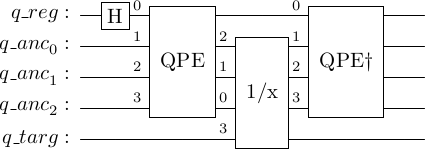

In [17]:
circ.draw('latex')

In [18]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [19]:
print(state_vector[16],state_vector[17])

(-0.7071067811865481+4.932632734248251e-16j) (-0.2290763333416968+1.4409046872332354e-16j)


In [20]:
state_v = np.asarray(state_vector).reshape((2**1,2**nanc,2**n))#.T

In [21]:
# 1, nanc, n
print(state_v.shape)

(2, 8, 2)


In [22]:
norm = np.sqrt(np.sum(np.abs(state_v[1])**2))

In [23]:
state_v = np.sum(state_v[1], axis=0)

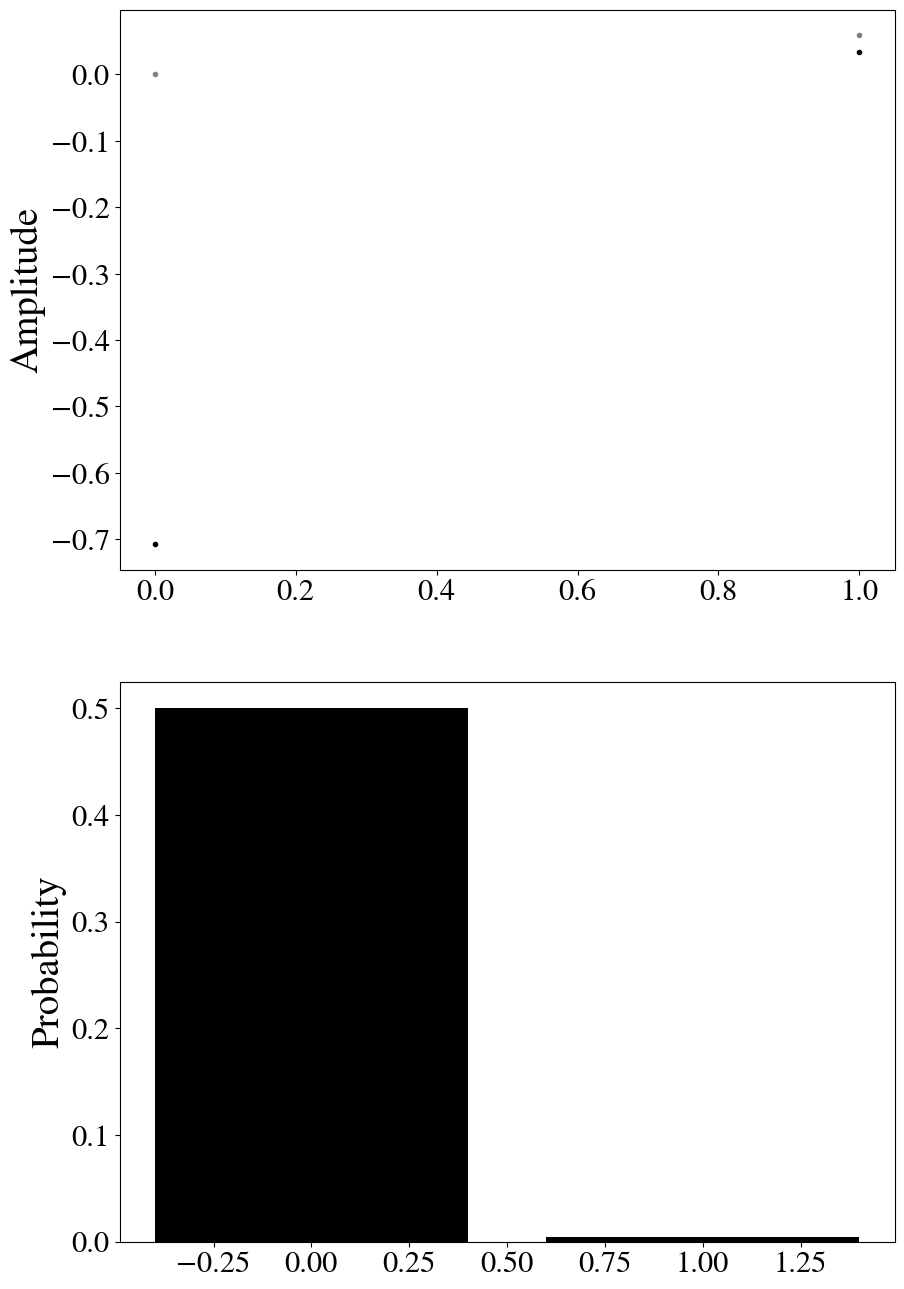

In [24]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(np.arange(2**n), state_v.real, marker='.', color='black')
plt.scatter(np.arange(2**n), state_v.imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.bar(np.arange(2**n), np.abs(state_v)**2, color='black')
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [25]:
state_v = state_v.real/np.sqrt(np.sum(np.abs(state_v)**2))

In [26]:
targ = np.matmul(np.linalg.inv(A),in_vector)

In [27]:
norm = norm/lambda_min

In [28]:
out = state_v*norm

In [29]:
print(out, targ)

[-6.08745047  0.29503801] [-5.65685425+0.j -2.12132034+0.j]
